In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from giems_lstm.config import Config
import os

os.chdir("..")

## Check Up & Preprocess

In [2]:
pred = xr.open_dataset("output/F_prediction.nc")
pred

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 492, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1984-01-01 1984-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    fwet     (time, lat, lon) float32 2GB ...

In [3]:
config = Config("config/E.toml", "analyze")
TVARs = config.TVARs
TVARs.keys()

dict_keys(['giems2', 'era5', 'mswep', 'gleam', 'grace'])

In [4]:
train_years = config.train.train_years
train_years

[1992,
 1993,
 1994,
 2003,
 2004,
 2005,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2018,
 2019]

In [5]:
mask = config.mask
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [6]:
pixel_area = xr.open_dataset("data/clean/PixelArea_area.nc")
pixel_area

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    area     (lat, lon) float64 8MB ...

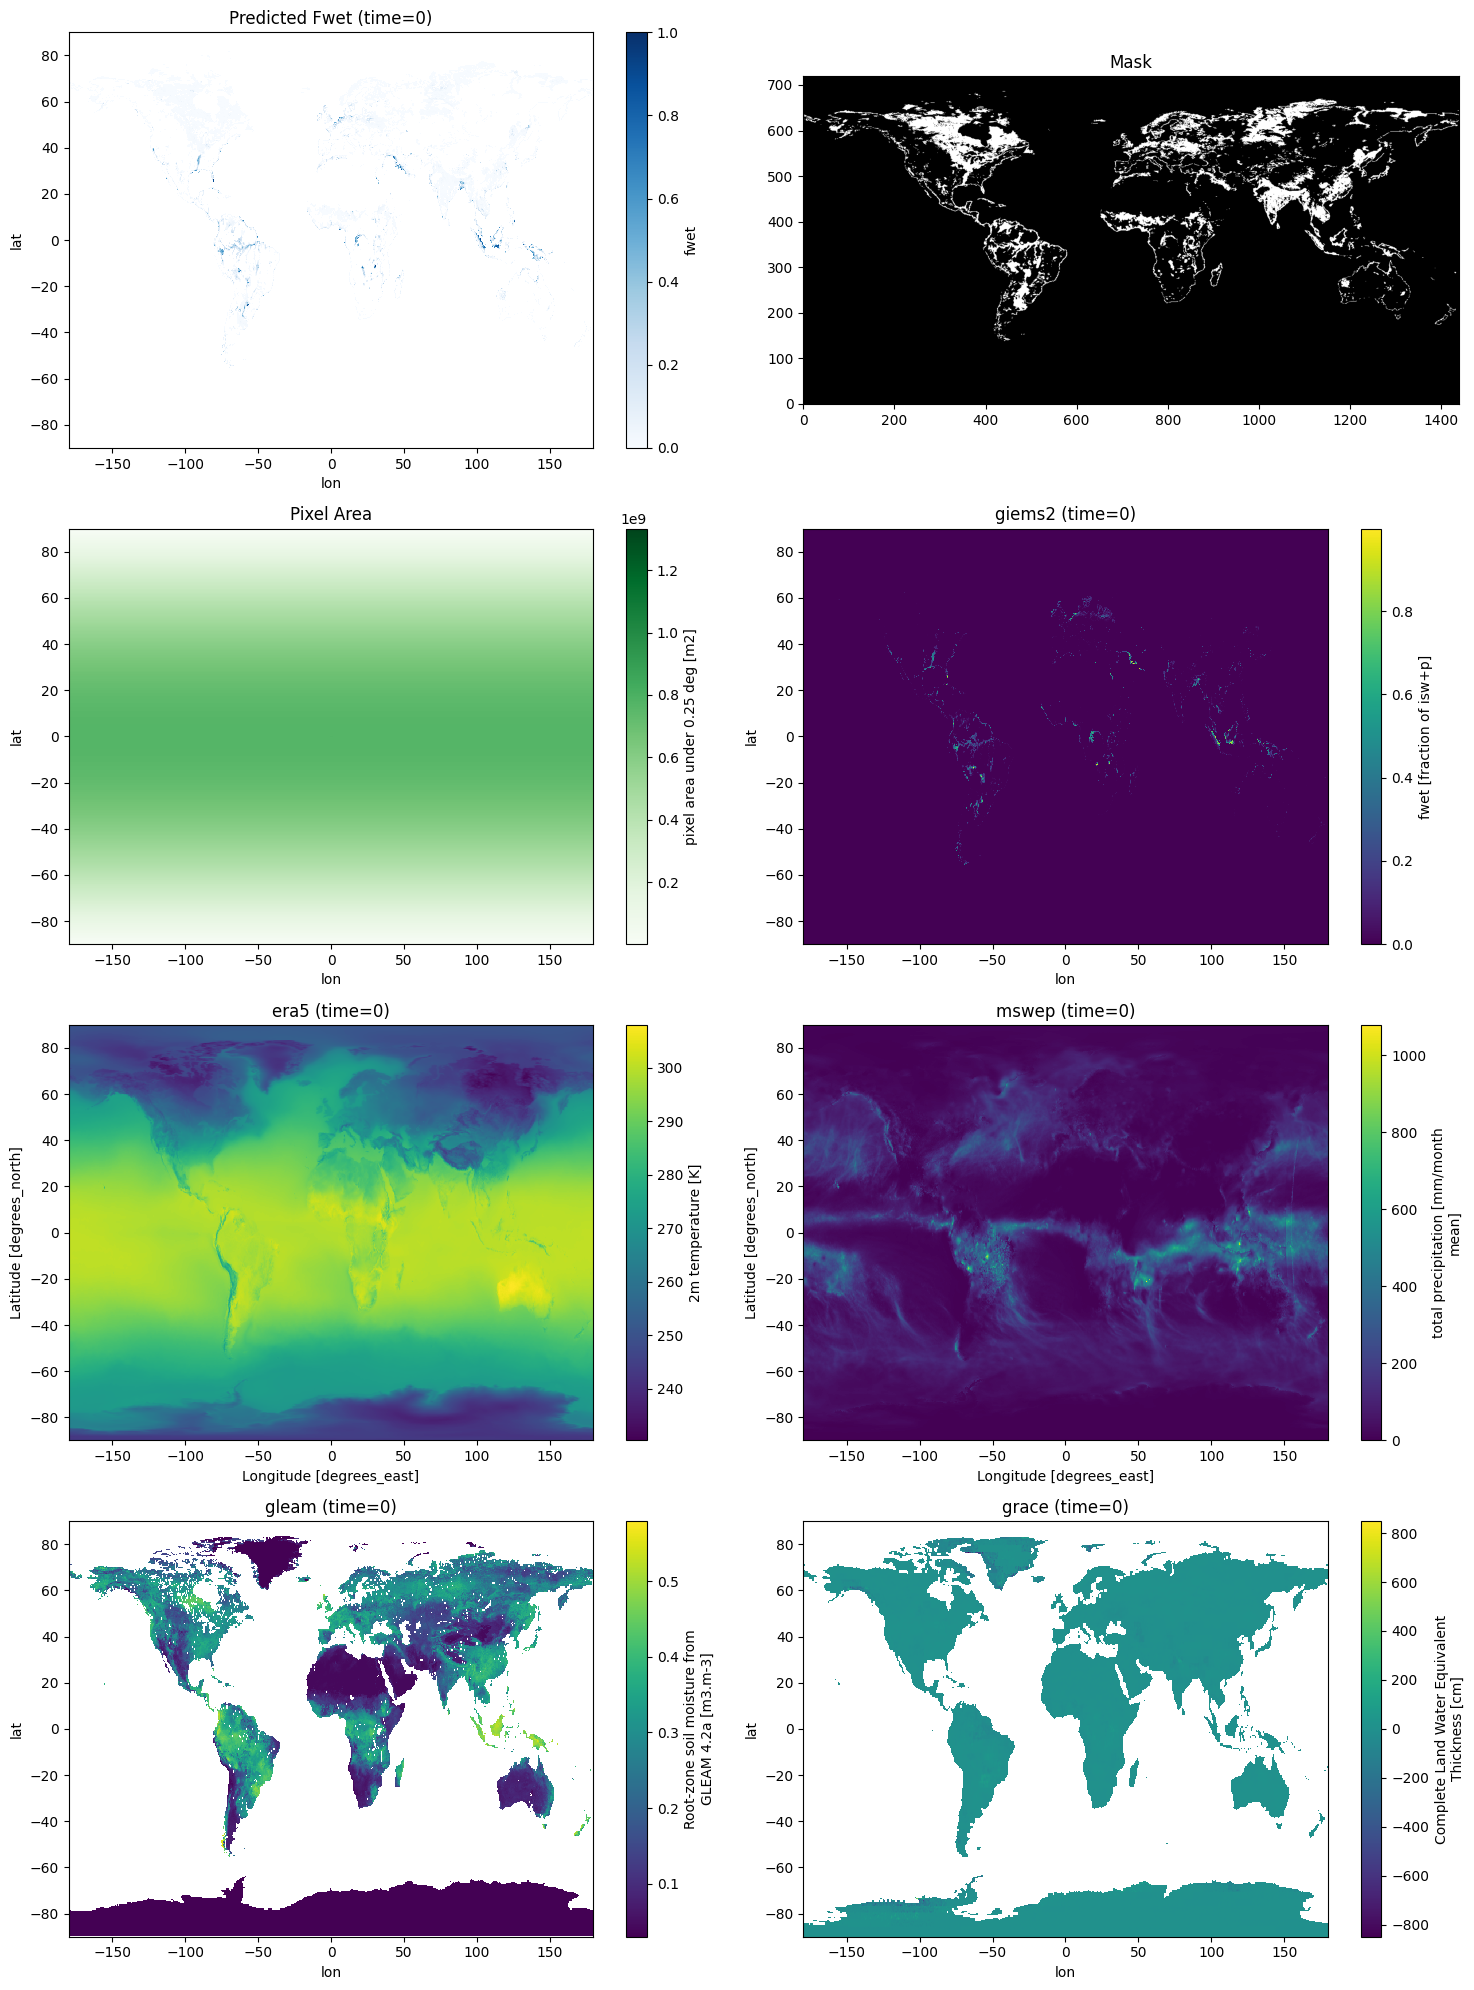

In [7]:
# Overall view
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

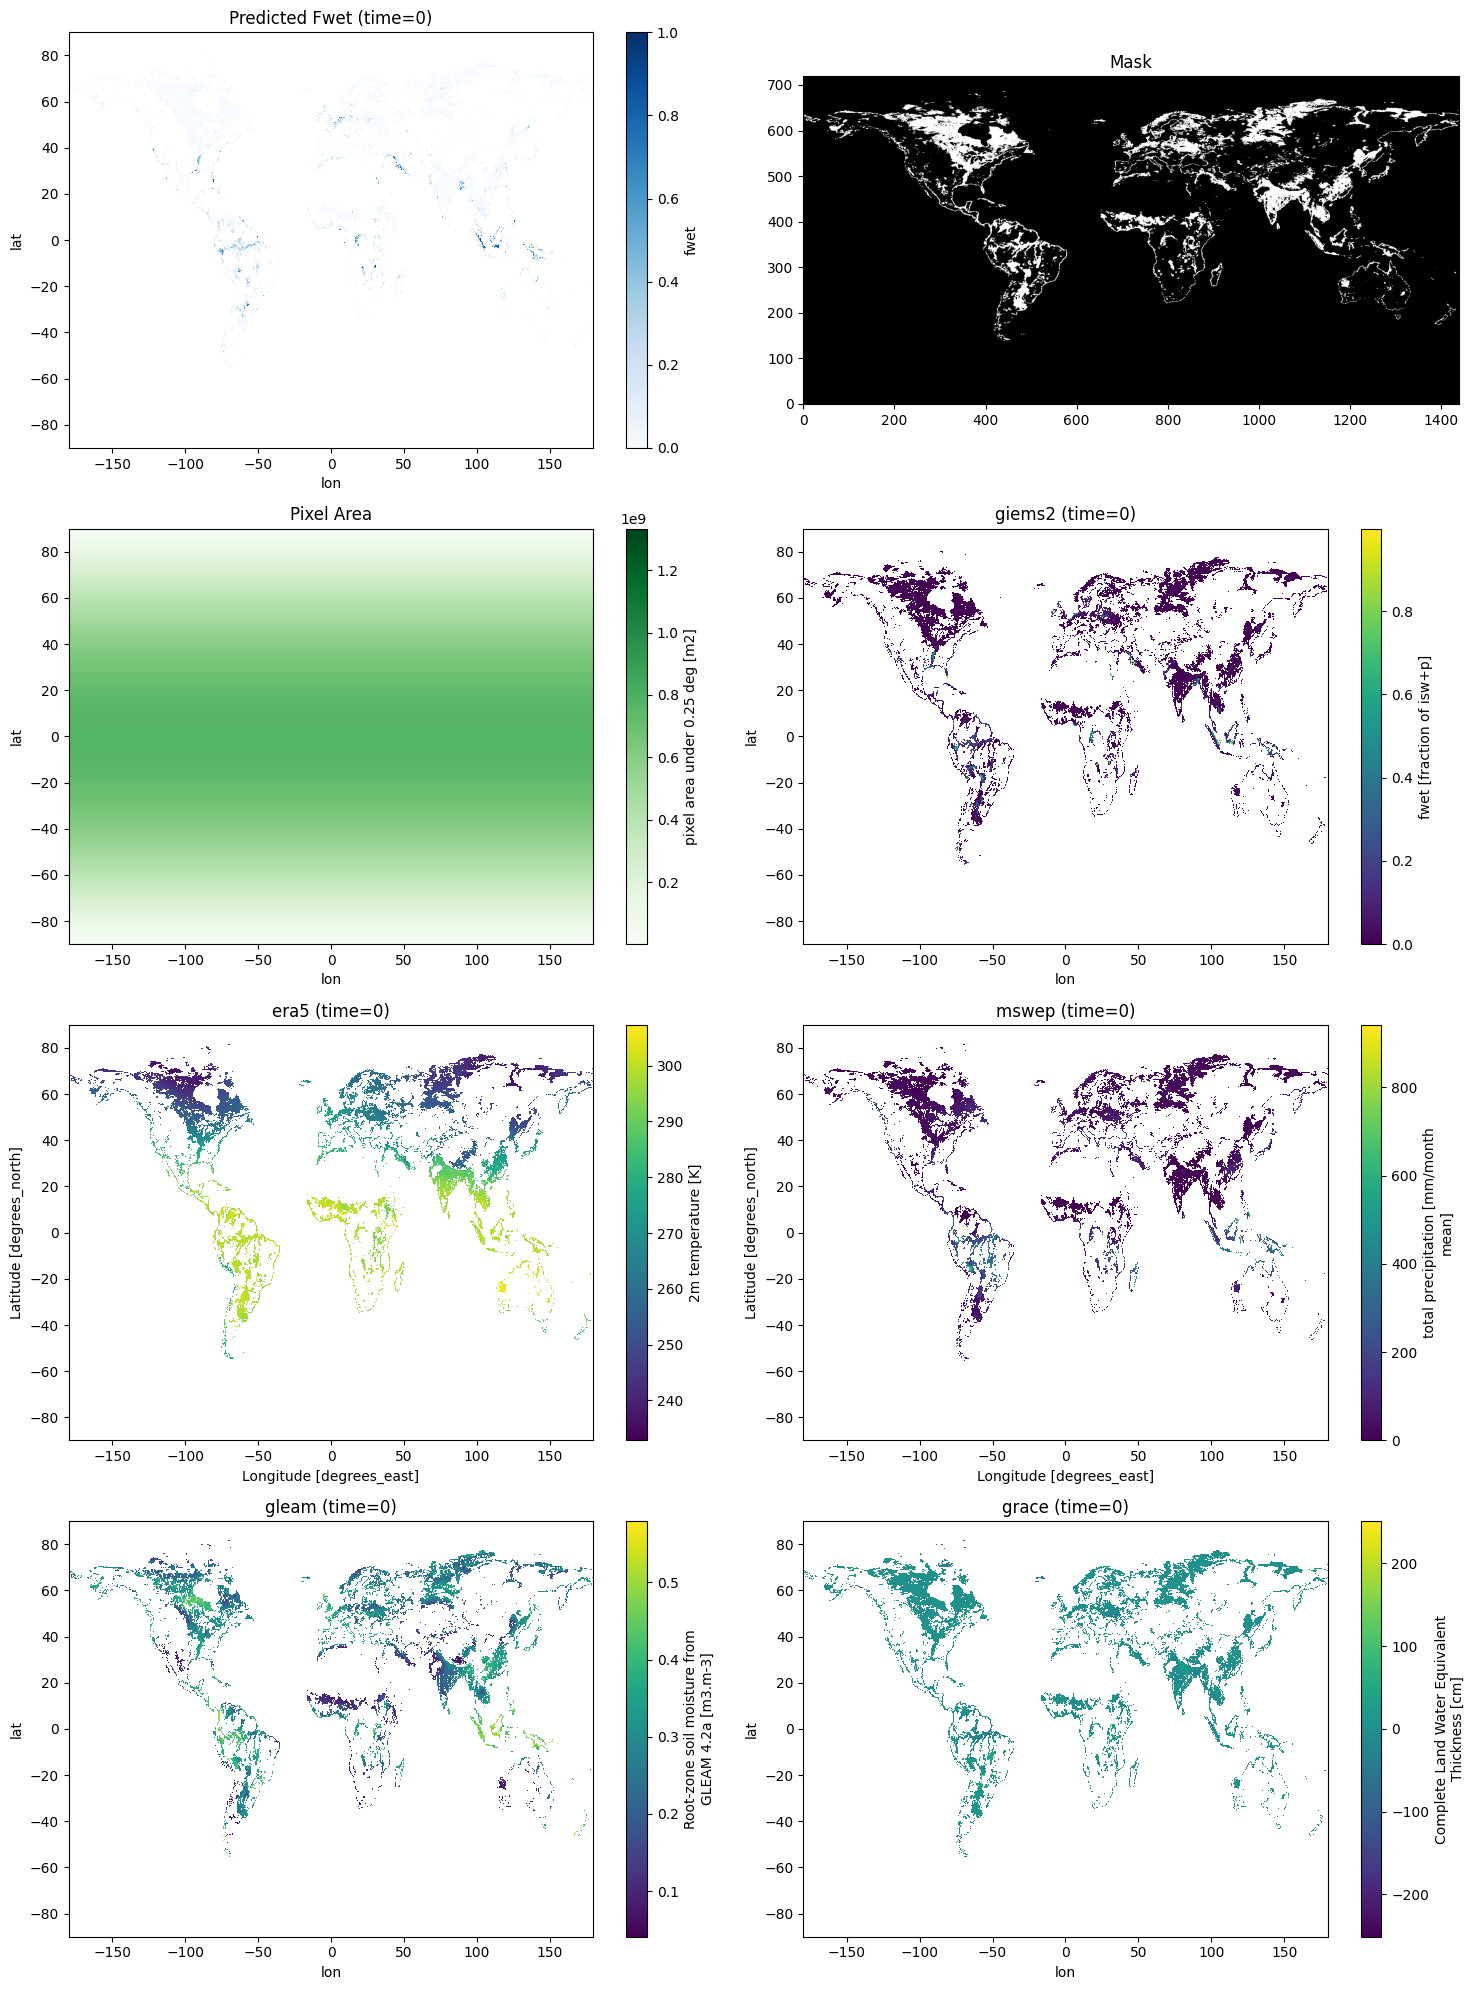

In [8]:
# all the data need to be masked
for var in TVARs.keys():
    TVARs[var] = TVARs[var].where(mask)

pred = pred.transpose("time", "lat", "lon")
pred["fwet"] = pred["fwet"].where(mask)

# check again
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()
pred["fwet"].isel(time=0).plot(ax=axes[0], cmap="Blues", vmin=0, vmax=1)
axes[0].set_title("Predicted Fwet (time=0)")
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Mask")
# flip upside down for mask
axes[1].invert_yaxis()
pixel_area["area"].plot(ax=axes[2], cmap="Greens")
axes[2].set_title("Pixel Area")

for i, var in enumerate(TVARs.keys()):
    TVARs[var].isel(time=0).plot(ax=axes[i + 3], cmap="viridis")
    axes[i + 3].set_title(f"{var} (time=0)")
fig.tight_layout()

In [9]:
# apply weights
pred_area = pred["fwet"] * pixel_area["area"]
giems_area = TVARs["giems2"] * pixel_area["area"]

weight = np.nanmax(TVARs["giems2"].values, axis=0)
grace_weighted = TVARs["grace"] * weight
mswep_weighted = TVARs["mswep"] * weight
gleam_weighted = TVARs["gleam"] * weight

C:\Users\FireFighter\AppData\Local\Temp\ipykernel_29112\70453930.py:5: RuntimeWarning: All-NaN slice encountered
  weight = np.nanmax(TVARs["giems2"].values, axis=0)


## Global

In [10]:
def compute_GY(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="YS").mean()


pred_area_GY = compute_GY(pred_area)
giems_area_GY = compute_GY(giems_area)
grace_weighted_GY = compute_GY(grace_weighted)
mswep_weighted_GY = compute_GY(mswep_weighted)
gleam_weighted_GY = compute_GY(gleam_weighted)

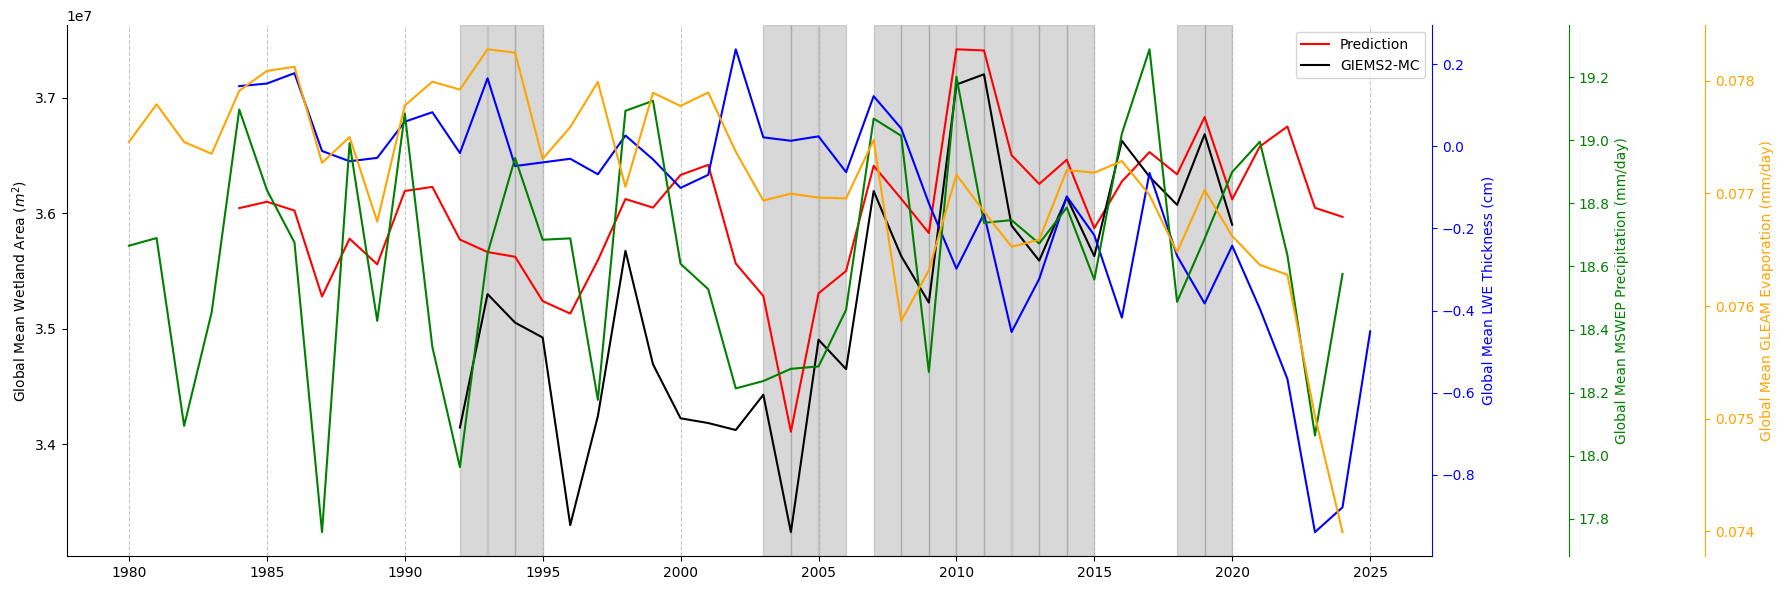

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred_area_GY.time,
    pred_area_GY,
    label="Prediction",
    color="red",
)
ax.plot(
    giems_area_GY.time,
    giems_area_GY,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel("Global Mean Wetland Area ($m^2$)")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


def draw_compare(dataarray, offset, label, color):
    bx = ax.twinx()
    bx.plot(
        dataarray.time,
        dataarray,
        color=color,
    )
    bx.spines["right"].set_position(("axes", offset))
    bx.spines["right"].set_color(color)
    bx.spines["left"].set_visible(False)
    bx.spines["top"].set_visible(False)
    bx.spines["bottom"].set_visible(False)
    bx.grid(False)
    bx.set_ylabel(label, color=color)
    bx.yaxis.label.set_color(color)
    bx.tick_params(axis="y", colors=color)


draw_compare(grace_weighted_GY, 1, "Global Mean LWE Thickness (cm)", "blue")
draw_compare(
    mswep_weighted_GY, 1.1, "Global Mean MSWEP Precipitation (mm/day)", "green"
)
draw_compare(gleam_weighted_GY, 1.2, "Global Mean GLEAM Evaporation (mm/day)", "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

fig.tight_layout()

In [12]:
# Let's see global monthly
def compute_GM(dataarray: xr.DataArray):
    return dataarray.mean(dim=["lat", "lon"], skipna=True).resample(time="MS").mean()


pred_area_GM, giems_area_GM, grace_weighted_GM, mswep_weighted_GM, gleam_weighted_GM = (
    map(
        compute_GM,
        [
            pred_area,
            giems_area,
            grace_weighted,
            mswep_weighted,
            gleam_weighted,
        ],
    )
)

In [13]:
"""Template for plotting
pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()

draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()
"""

'Template for plotting\npred, giems, grace, mswep, gleam = datas\nfig, ax = plt.subplots(figsize=(18, 6))\nax.plot(\n    pred.time,\n    pred,\n    label="Prediction",\n    color="red",\n)\nax.plot(\n    giems.time,\n    giems,\n    label="GIEMS2-MC",\n    color="black",\n)\nax.set_ylabel(ylabel["giems"])\nax.spines["right"].set_visible(False)\nax.spines["top"].set_visible(False)\nax.grid(True, axis="x", linestyle="--", alpha=0.7)\nax.legend()\n\ndraw_compare(grace, 1, ylabel["grace"], "blue")\ndraw_compare(mswep, 1.1, ylabel["mswep"], "green")\ndraw_compare(gleam, 1.2, ylabel["gleam"], "orange")\n\n# shade train years\nfor year in train_years:\n    ax.axvspan(\n        np.datetime64(f"{year}-01-01"),\n        np.datetime64(f"{year}-12-31"),\n        color="gray",\n        alpha=0.3,\n    )\nfig.suptitle(title)\nfig.tight_layout()\n'

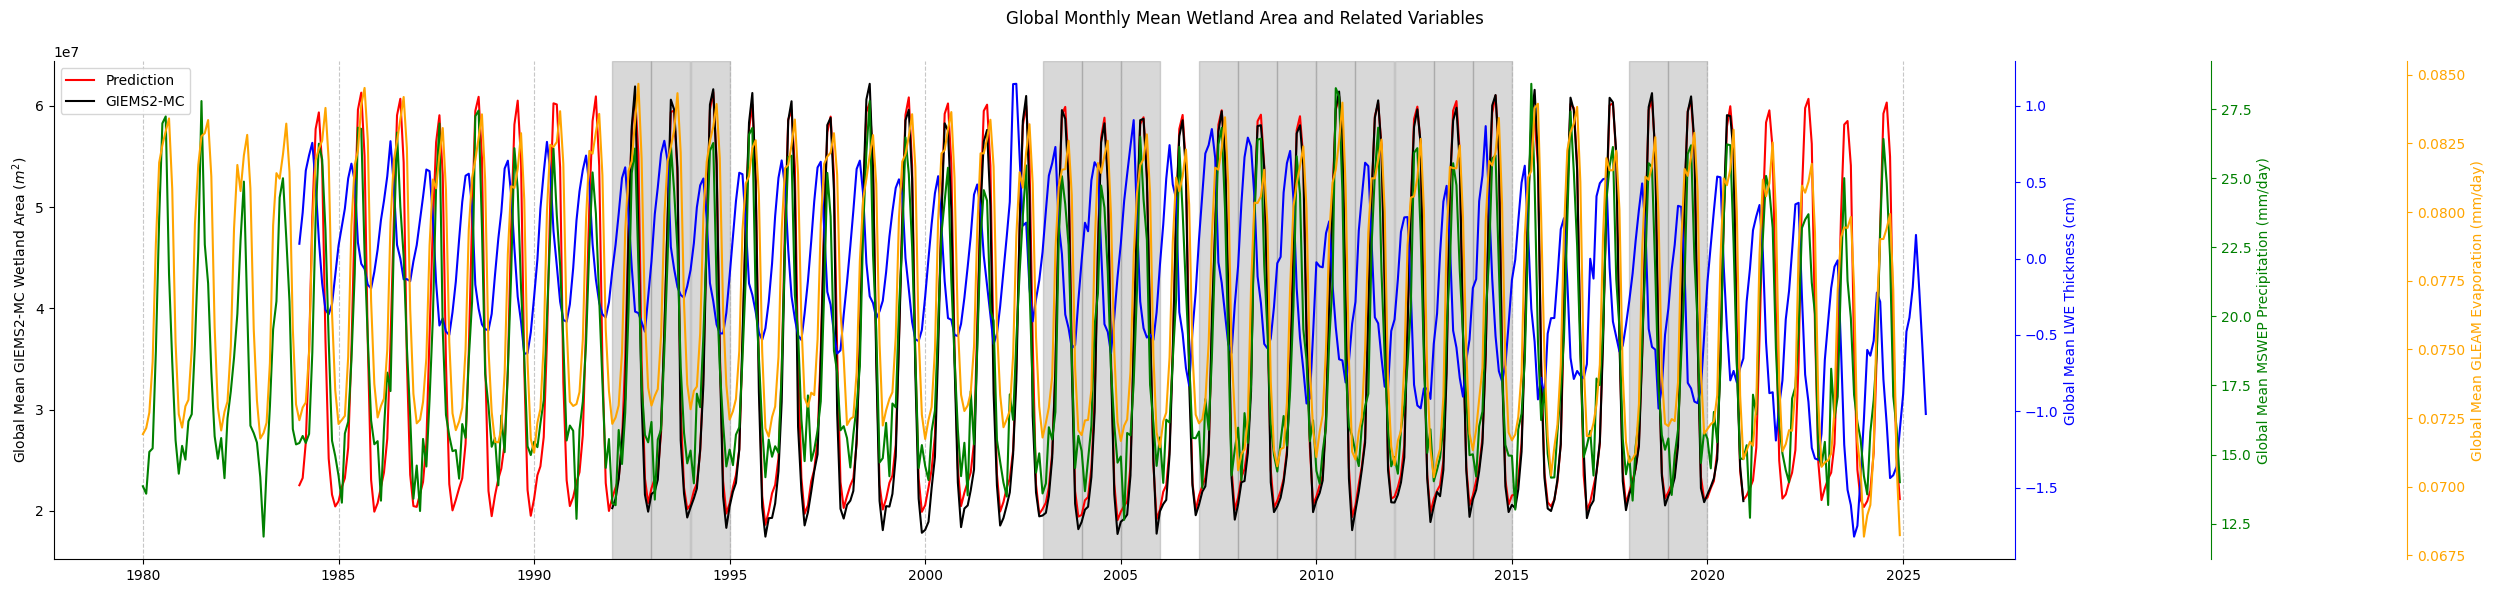

In [14]:
datas = (
    pred_area_GM,
    giems_area_GM,
    grace_weighted_GM,
    mswep_weighted_GM,
    gleam_weighted_GM,
)
title = "Global Monthly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Global Mean Predicted Wetland Area ($m^2$)",
    "giems": "Global Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Global Mean LWE Thickness (cm)",
    "mswep": "Global Mean MSWEP Precipitation (mm/day)",
    "gleam": "Global Mean GLEAM Evaporation (mm/day)",
}


pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()

draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")
# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

## Tropical

lat : -30 to 30

In [15]:
def compute_TY(dataarray: xr.DataArray):
    return (
        dataarray.sel(lat=slice(-30, 30))
        .mean(dim=["lat", "lon"], skipna=True)
        .resample(time="YS")
        .mean()
    )


datas = (
    compute_TY(pred_area),
    compute_TY(giems_area),
    compute_TY(grace_weighted),
    compute_TY(mswep_weighted),
    compute_TY(gleam_weighted),
)

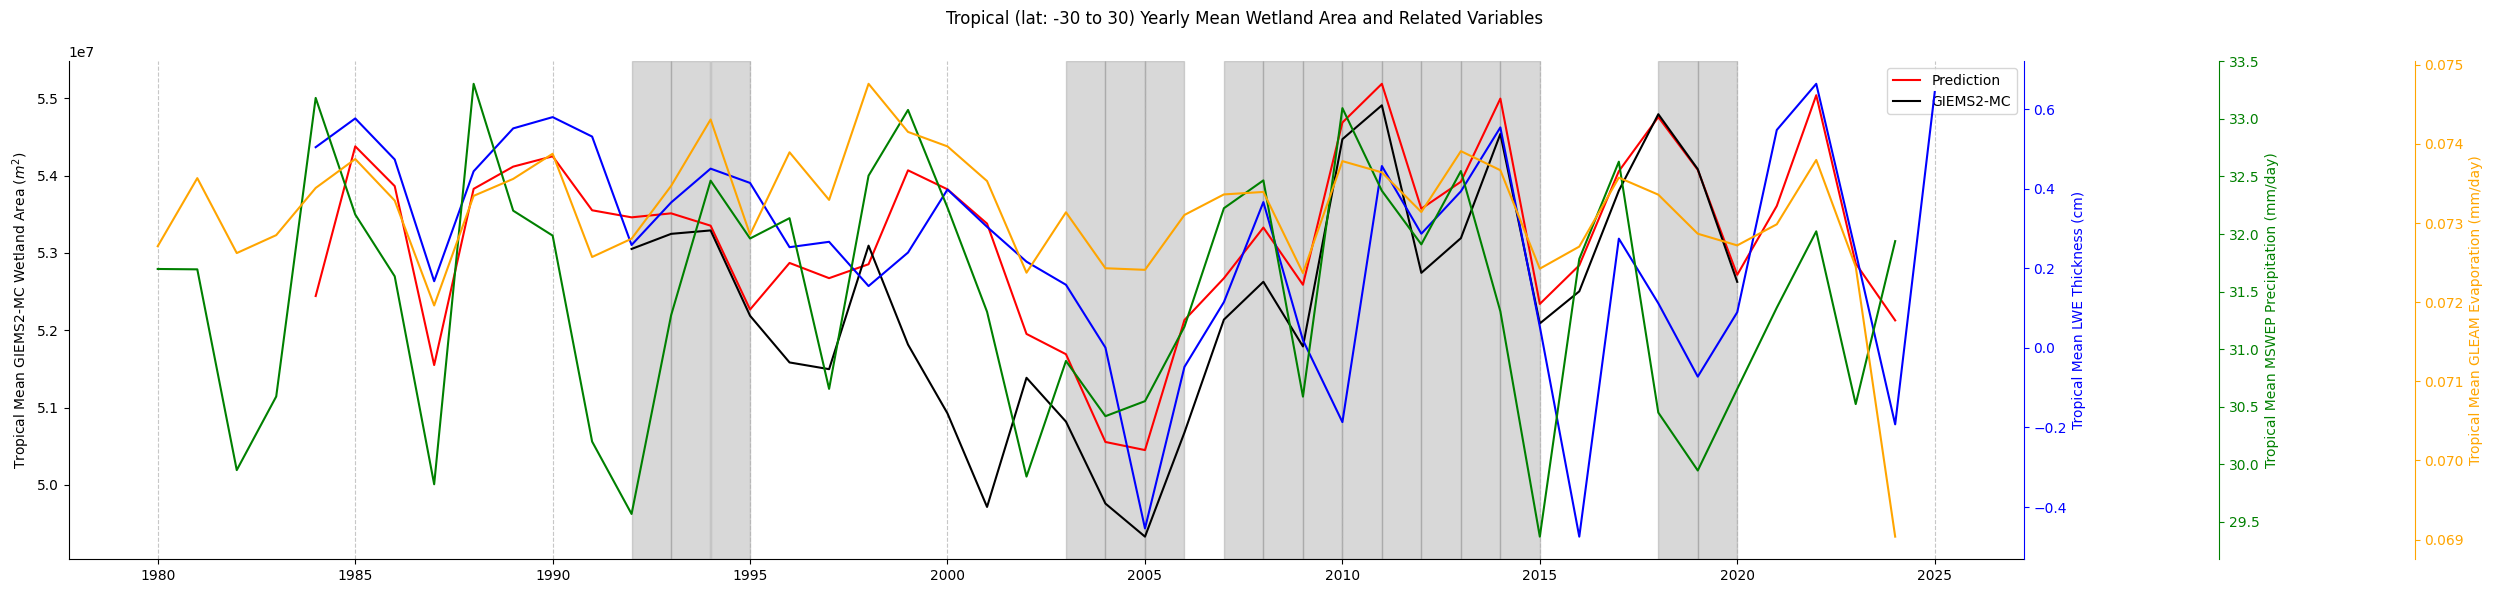

In [16]:
title = "Tropical (lat: -30 to 30) Yearly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Tropical Mean Predicted Wetland Area ($m^2$)",
    "giems": "Tropical Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Tropical Mean LWE Thickness (cm)",
    "mswep": "Tropical Mean MSWEP Precipitation (mm/day)",
    "gleam": "Tropical Mean GLEAM Evaporation (mm/day)",
}

pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

In [17]:
# Tropical Monthly
def compute_TM(dataarray: xr.DataArray):
    return (
        dataarray.sel(lat=slice(-30, 30))
        .mean(dim=["lat", "lon"], skipna=True)
        .resample(time="MS")
        .mean()
    )


datas = (
    compute_TM(pred_area),
    compute_TM(giems_area),
    compute_TM(grace_weighted),
    compute_TM(mswep_weighted),
    compute_TM(gleam_weighted),
)

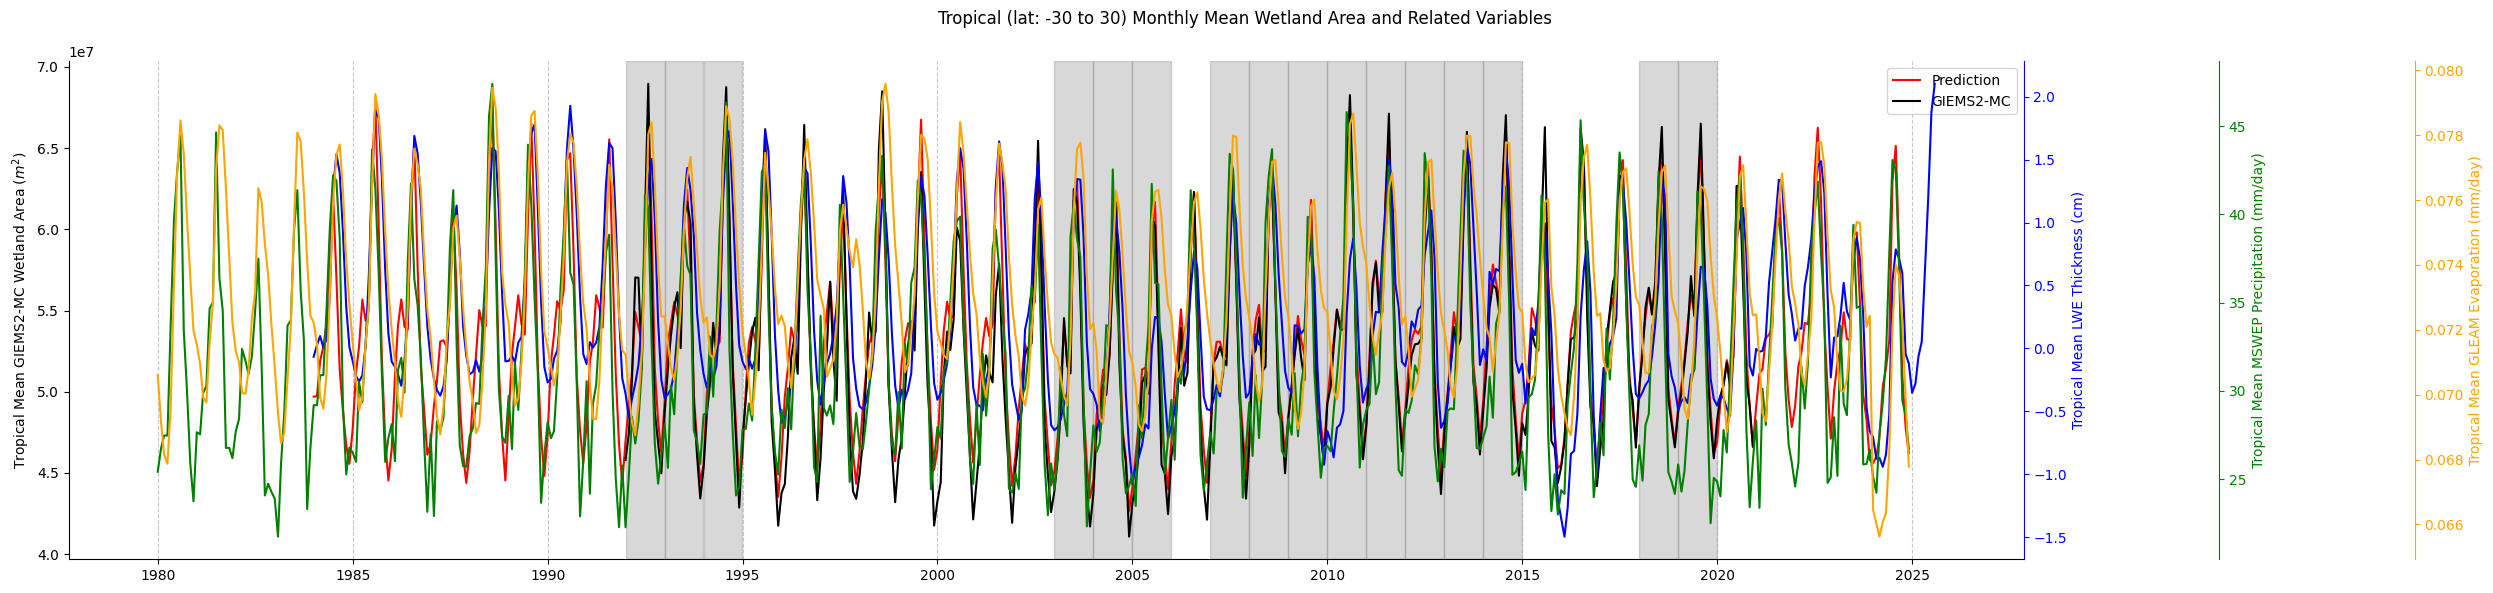

In [18]:
title = "Tropical (lat: -30 to 30) Monthly Mean Wetland Area and Related Variables"
ylabel = {
    "pred": "Tropical Mean Predicted Wetland Area ($m^2$)",
    "giems": "Tropical Mean GIEMS2-MC Wetland Area ($m^2$)",
    "grace": "Tropical Mean LWE Thickness (cm)",
    "mswep": "Tropical Mean MSWEP Precipitation (mm/day)",
    "gleam": "Tropical Mean GLEAM Evaporation (mm/day)",
}

pred, giems, grace, mswep, gleam = datas
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(
    pred.time,
    pred,
    label="Prediction",
    color="red",
)
ax.plot(
    giems.time,
    giems,
    label="GIEMS2-MC",
    color="black",
)
ax.set_ylabel(ylabel["giems"])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(True, axis="x", linestyle="--", alpha=0.7)
ax.legend()


draw_compare(grace, 1, ylabel["grace"], "blue")
draw_compare(mswep, 1.1, ylabel["mswep"], "green")
draw_compare(gleam, 1.2, ylabel["gleam"], "orange")

# shade train years
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )
fig.suptitle(title)
fig.tight_layout()

## RMSE of Global Mean Time Series

In [19]:
time = giems.time
pred_selected = pred_area.sel(time=time)
pred_selected

<xarray.DataArray (time: 348, lat: 720, lon: 1440)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2

In [20]:
# Calculate RMSE on each grid cell
rmse_grid = np.sqrt(((pred_selected - giems_area) ** 2).mean(dim="time", skipna=True))
rmse_grid

<xarray.DataArray (lat: 720, lon: 1440)> Size: 8MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

Text(0.5, 1.0, 'RMSE of Predicted Wetland Area ($m^2$)')

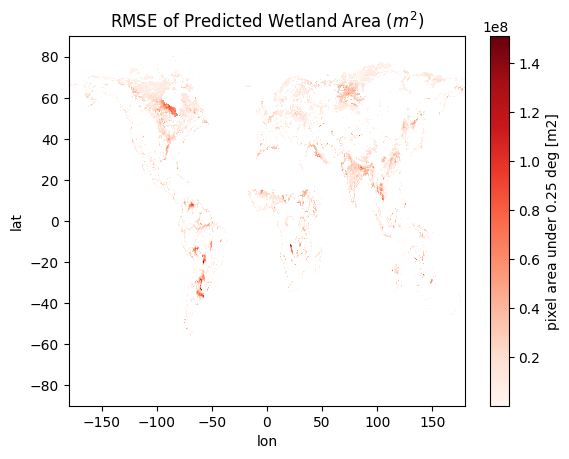

In [21]:
rmse_grid.plot(cmap="Reds")
plt.title("RMSE of Predicted Wetland Area ($m^2$)")

In [22]:
rmse_time = np.sqrt(
    ((pred_selected - giems_area) ** 2).mean(dim=["lat", "lon"], skipna=True)
)
rmse_time

<xarray.DataArray (time: 348)> Size: 3kB
array([20446865.37710606, 22577904.26133926, 22619186.88800088,
       23081222.1377553 , 35927699.74520905, 27893904.06416877,
       29920114.5247964 , 26227906.99822756, 35541671.17142979,
       35214946.36649259, 22258161.22671812, 10114101.4443328 ,
       11176224.13132242, 13795691.59252313, 12579019.99872389,
       14292161.65938373, 18502181.55151847, 21666836.17610398,
       15573464.82789716, 16787352.46048886, 18020036.23168101,
       18997557.74558337, 12539634.54721134,  8778466.27232891,
       10557133.44200264, 10764071.00357128, 10980312.11484131,
       12795976.4724573 , 16986580.94023511, 16018258.40982256,
       16909274.44597208, 17986167.38985353, 15867271.59024497,
       16780835.07718422, 10471843.81863393,  7846556.79210139,
       17194419.60349694, 19364212.73682954, 19379127.11493477,
       21504159.80462147, 34260447.49624797, 20986928.51620097,
       22283692.34690472, 22826328.26199815, 24411764.48288711,
       40010973.72030548, 20493546.46257266, 16114555.3559416 ,
       18610245.18860187, 22042696.05608705, 20835834.87509224,
       21843609.07747394, 35194647.88500396, 28003160.67406973,
       24753615.62124297, 24794553.08406649, 29303938.71801642,
       36346653.71606981, 22385786.82392033, 17085329.33789387,
...
       18638564.36734116, 20408651.57208607, 20767336.46797655,
       21968110.77713972, 32260607.0002705 , 22934610.93402809,
       22899701.27137088, 20809729.48857683, 21699515.65897001,
       33789102.36091667, 31022134.46587447, 15494993.06492806,
       17202693.57535065, 19067272.45073761, 17402603.0134904 ,
       22086533.13863852, 35077554.86364647, 26231651.58444434,
       21168893.82331578, 20849814.95489596, 21354540.01507992,
       34185767.08859964, 20436112.00789282, 14336551.12560263,
       11370236.86790838, 10823949.09344658, 11625605.33405084,
       11940165.36701578, 13879499.8270918 , 12355864.27425581,
       12666882.88826258, 12976476.73785666, 12743131.29664738,
       14003615.09997979, 10859841.49878127,  9173195.52370375,
       10009204.8782013 , 13128185.97785079,  9833435.32252848,
       11212452.52766131, 19646604.48724869, 11901344.3597382 ,
       12113416.82663741, 13272162.48395187, 11681404.78651481,
       14047432.09033249,  8807407.0862415 , 10729034.55918641,
       17056993.14285176, 21746827.10190208, 18430596.55631619,
       19755108.00815506, 34572871.97348788, 23413496.46558502,
       22962935.86711471, 21280839.42868873, 21816276.73585273,
       33524501.55429592, 23071987.57362278, 17691228.80964787])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

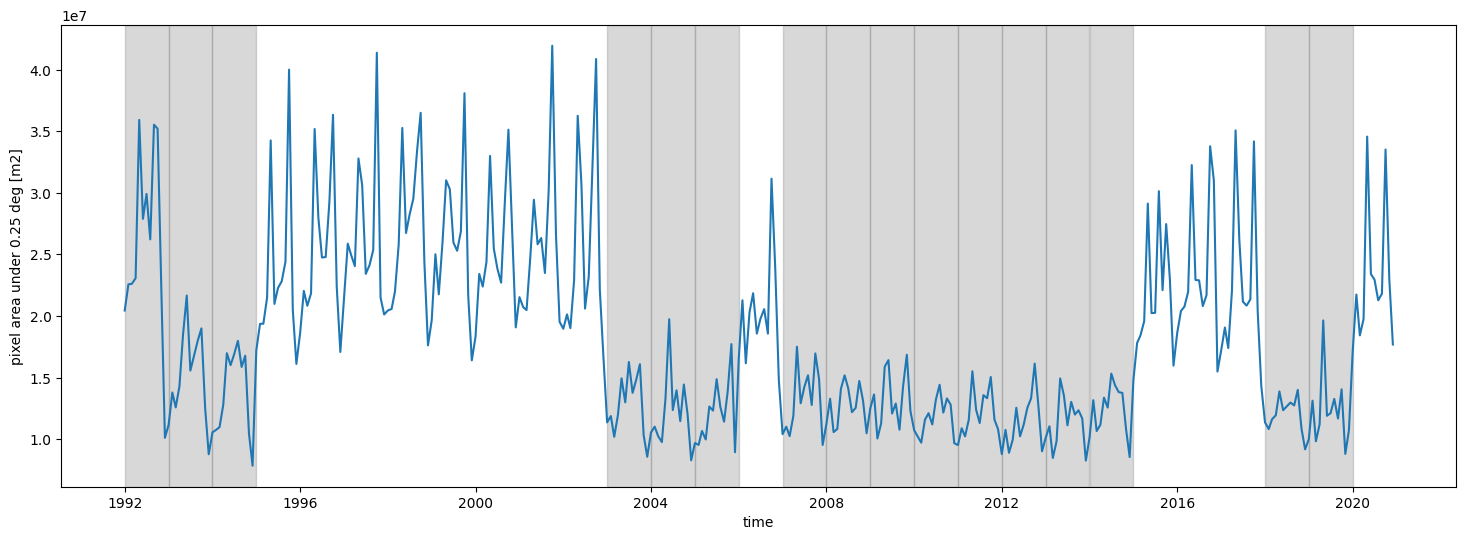

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))
rmse_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

In [24]:
# sMAPE = 2 * |F - A| / (|F| + |A|)
smape = (
    2
    * np.abs(pred_selected - giems_area)
    / (np.abs(pred_selected) + np.abs(giems_area))
)
smape_time = smape.mean(dim=["lat", "lon"], skipna=True)
smape_time

<xarray.DataArray (time: 348)> Size: 3kB
array([1.5069632 , 1.51509574, 1.47106043, 1.39477418, 1.26160052,
       0.95689918, 0.66232612, 0.55950141, 0.85610328, 1.2633672 ,
       1.4482467 , 1.4684391 , 1.48788977, 1.50224857, 1.4800383 ,
       1.33974952, 1.14135453, 0.86686618, 0.52898465, 0.5458301 ,
       0.69907212, 1.24315607, 1.41415609, 1.4821437 , 1.48100837,
       1.49727031, 1.47875731, 1.37541673, 1.18337765, 0.86383664,
       0.52777724, 0.51086924, 0.6668142 , 1.08856733, 1.38393675,
       1.47033632, 1.51055976, 1.49659615, 1.47456798, 1.3964593 ,
       1.19968344, 0.87640201, 0.59269459, 0.55357028, 0.7544512 ,
       1.17801346, 1.45866569, 1.53898582, 1.53581928, 1.54404491,
       1.52223945, 1.46668265, 1.26340864, 0.92619131, 0.61696977,
       0.56049301, 0.75624874, 1.24722091, 1.42183958, 1.52416516,
       1.54068452, 1.51425878, 1.48007322, 1.42098643, 1.21116892,
       0.91426416, 0.59148622, 0.56595215, 0.7199857 , 1.24661714,
       1.44582827, 1.5000503 , 1.50140203, 1.49711648, 1.49538699,
       1.3944583 , 1.19082183, 0.8770846 , 0.57868078, 0.55199229,
       0.7577646 , 1.19281543, 1.47158969, 1.53599145, 1.51933302,
       1.53947218, 1.51008933, 1.41470231, 1.20539637, 0.93390451,
       0.595859  , 0.55665559, 0.74087933, 1.20306435, 1.45672956,
       1.52852472, 1.55310996, 1.5389757 , 1.48439583, 1.39817171,
...
       1.34338254, 1.49790589, 1.50135446, 1.48830045, 1.48565845,
       1.42187953, 1.14190866, 0.74253342, 0.50941898, 0.48980027,
       0.57049962, 0.97899212, 1.3174884 , 1.46785156, 1.47899814,
       1.4719275 , 1.41522366, 1.32079159, 1.12683981, 0.7555381 ,
       0.51593453, 0.47530943, 0.57598802, 1.06591105, 1.34673419,
       1.43891457, 1.48340688, 1.49119395, 1.44884423, 1.36357601,
       1.15632227, 0.8365731 , 0.55572086, 0.5310461 , 0.61533714,
       1.13794617, 1.3753954 , 1.45059711, 1.50725237, 1.47994896,
       1.44384256, 1.35289725, 1.11410292, 0.81838571, 0.52899116,
       0.51318275, 0.62937395, 1.1200987 , 1.40661445, 1.49634522,
       1.51064049, 1.49486652, 1.43889244, 1.36853686, 1.17954563,
       0.87219918, 0.54483493, 0.50754103, 0.59919543, 1.12083029,
       1.3767579 , 1.46616042, 1.45312543, 1.46486617, 1.45555427,
       1.37688021, 1.13101621, 0.88113782, 0.50685423, 0.47995653,
       0.58288789, 1.0170253 , 1.33041884, 1.44600976, 1.46628501,
       1.45589263, 1.40957565, 1.31768147, 1.09694116, 0.76813942,
       0.4916211 , 0.47181081, 0.54233805, 0.99250855, 1.34351421,
       1.40659507, 1.44870197, 1.45723707, 1.42356968, 1.35658784,
       1.1904248 , 0.8598651 , 0.55185121, 0.52023811, 0.58894867,
       1.13782313, 1.35871142, 1.44032776])
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-01 1992-02-01 ... 2020-12-01
Attributes:
    long_name:     pixel area under 0.25 deg
    generated_by:  Yifan Cheng
    units:         m2
    source:        pixels to be trained (no constant peatlands, no snow cover...

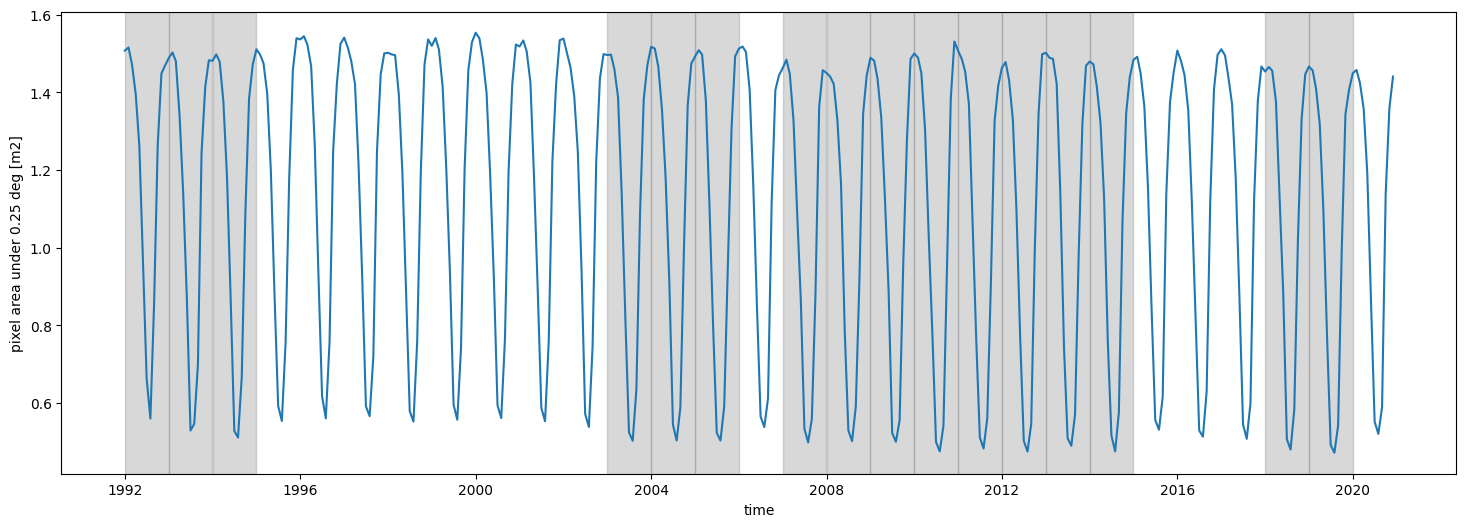

In [25]:
fig, ax = plt.subplots(figsize=(18, 6))
smape_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

In [26]:
# Accuracy = 1 - |F - A| / A
accuracy = 1 - np.divide(
    np.abs(pred_selected - giems_area),
    giems_area,
    out=np.zeros_like(pred_selected),
    where=giems_area != 0,
)
accuracy_time = accuracy.mean(dim=["lat", "lon"], skipna=True)
accuracy_grid = accuracy.mean(dim="time", skipna=True)

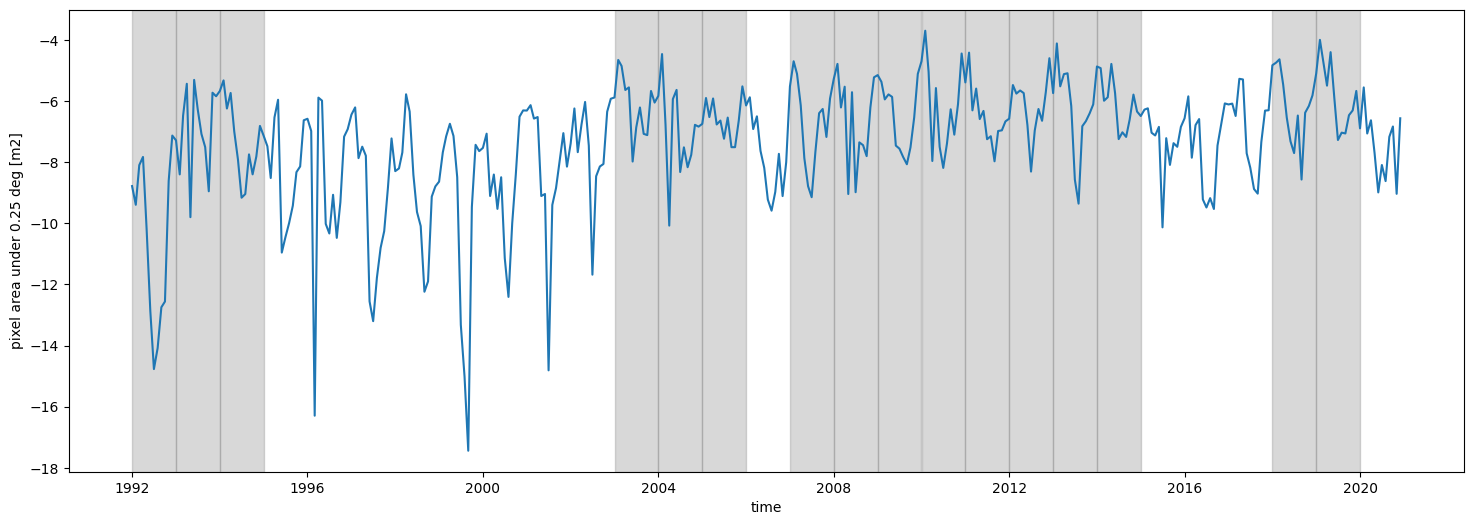

In [27]:
fig, ax = plt.subplots(figsize=(18, 6))
accuracy_time.plot(ax=ax)
for year in train_years:
    ax.axvspan(
        np.datetime64(f"{year}-01-01"),
        np.datetime64(f"{year}-12-31"),
        color="gray",
        alpha=0.3,
    )

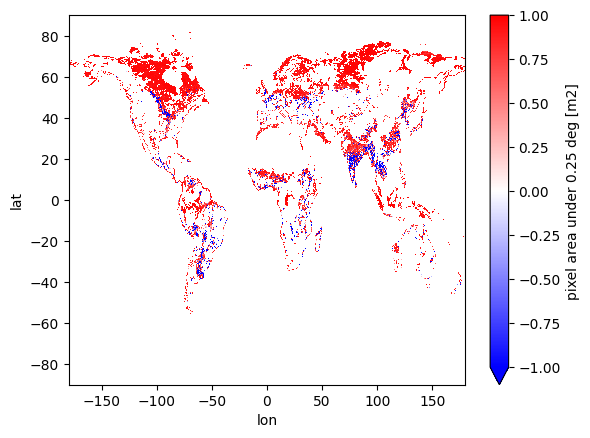

In [28]:
accuracy_grid.plot(vmax=1, vmin=-1, cmap="bwr")